In [1]:
import scipy
import nltk
import re

In [2]:
import sklearn

In [3]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data=pd.read_csv("dataset_svm.csv")
data.head(5)

,Unnamed: 0,subreddit,body,target
0,0,lgbt,Finally my first binder came in today and I'm ...,1
1,1,lgbt,Ok so growing up I've always loved girls no ma...,0
2,2,lgbt,"Hey, all! I wanted to make a help video on how...",0
3,3,lgbt,"I personally never have done it before,And I w...",0
4,4,lgbt,"Hello, I'm a Public Safety Officer at a relati...",1


In [5]:
data.shape
data.target.value_counts()

0    7837
1    4237
Name: target, dtype: int64

In [6]:
from nltk.corpus import stopwords
#nltk.download('stopwords')

stopwords = stopwords.words('english')

In [7]:
stemmer = nltk.PorterStemmer()

In [8]:
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

In [9]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n|\t', '', text)
    text = re.sub('\d', '', text) ##
    text = re.sub(r'[^\w\s]', ' ', text) ##
    text = [word for word in text.split() if word not in stopwords] 
    text = [stemmer.stem(word) for word in text]
    
    text = " ".join(text)
    
    return text

In [10]:
data['body']=data['body'].apply(preprocess)

In [11]:
#x = data.iloc[:, :-1]
#y = data.iloc[:, -1]
review = data['body'].values
label = data['target'].values
# check length of 1's and 0's
#one = np.where(y==1)
#zero = np.where(y==0)
#len(one[0]), len(zero[0])

In [12]:
x_train, x_test, y_train, y_test = train_test_split(review, label, test_size=0.2, random_state=42, stratify = data['target'])

# CNN

In [13]:
from sklearn.model_selection import train_test_split
review_train = x_train
label_train = y_train
review_test = x_test
label_test = y_test
#review_train
#review_train, review_test, label_train, label_test = train_test_split(review, label, test_size=0.25, random_state=1000) 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
review_vectorizer = CountVectorizer()
review_vectorizer.fit(review_train)
Xlr_train = review_vectorizer.transform(review_train)
Xlr_test  = review_vectorizer.transform(review_test)
print(label_train) 

[0 0 0 ... 1 0 0]


In [15]:
#from sklearn.linear_model import LogisticRegression
#LRmodel = LogisticRegression()
#LRmodel.fit(Xlr_train, label_train)
#score = LRmodel.score(Xlr_test, label_test)
#print("Accuracy:", score) 

In [16]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)
Xcnn_train = tokenizer.texts_to_sequences(review_train)
Xcnn_test = tokenizer.texts_to_sequences(review_test)
vocab_size = len(tokenizer.word_index) + 1  
print(review_train[1])
print(Xcnn_train[1])
print(label_train[1])

host movi screen decemb queer folk look someth queer holiday theme nostalgia valu peopl recommend movi think nostalg older crowd aunti mame stop motion rudolph special home holiday meet st loui pee wee christma episod etc someth recent queer millenni version aunti mame
[1417, 572, 2063, 2118, 203, 764, 35, 44, 203, 1304, 1556, 999, 5, 872, 572, 11, 529, 1924, 3948, 175, 4310, 802, 184, 1304, 209, 1418, 4514, 2328, 4793, 995, 1340, 186, 44, 120, 203, 1305, 3948]
0


In [17]:
from keras_preprocessing.sequence import pad_sequences
maxlen = 100
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

[  56   25 2529 1251 1015 4309  350  174  786 1382 1695   78   49   35
  174  572 1505   78  109  826  203   33  826  764  130  353    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [18]:
from keras.models import Sequential
from keras import layers 

In [19]:
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(128, 5, activation='relu'))
textcnnmodel.add(layers.LeakyReLU(alpha=0.01))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(10, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
textcnnmodel.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          3999800   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           128128    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 128)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

In [20]:

textcnnmodel.fit(Xcnn_train, label_train,
                     epochs=10,
                     verbose=False,
                     validation_data=(Xcnn_test, label_test),
                       batch_size=20)

In [21]:
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8306


76/76 [==============================] - 2s 5ms/step
[[1]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


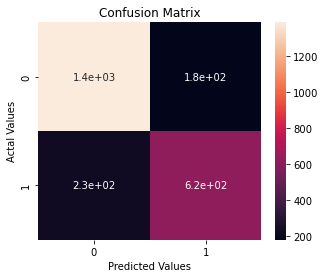

In [22]:
#model1.fit(X1_train, y1_train)  

#y_pred = textcnnmodel.predict(Xcnn_test)
y_pred=(textcnnmodel.predict(Xcnn_test) > 0.5).astype("int32")
print(y_pred)
cm = confusion_matrix(label_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = [0,1], 
                     columns = [0,1])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
#print(cm)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(label_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1568
           1       0.77      0.73      0.75       847

    accuracy                           0.83      2415
   macro avg       0.82      0.81      0.81      2415
weighted avg       0.83      0.83      0.83      2415



In [24]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [25]:
#!pip install scikit-plot
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import scikitplot as skplt
import matplotlib.pyplot as plt

76/76 [==============================] - 0s 5ms/step


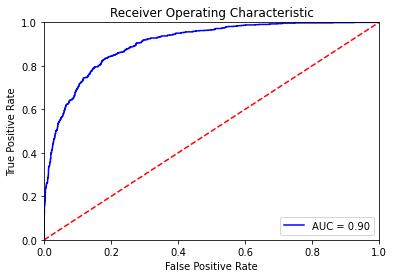

In [26]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = textcnnmodel.predict(Xcnn_test)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
#from ggplot import *
#df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

In [27]:
from sklearn.metrics import balanced_accuracy_score

print("balanced_accuracy", balanced_accuracy_score(y_test, y_pred))

balanced_accuracy 0.807419041996964


76/76 [==============================] - 0s 4ms/step
Model1: f1=0.751 auc=0.843


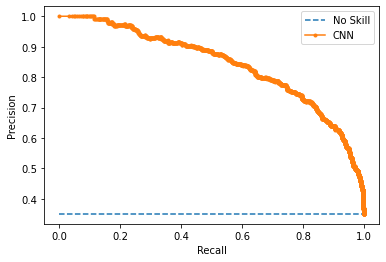

In [29]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
lr_probs = textcnnmodel.predict(Xcnn_test)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# predict class values
#yhat = grid1.predict(x_test)
yhat=(textcnnmodel.predict(Xcnn_test) > 0.5).astype("int32")
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Model1: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='CNN')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()